In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
os.listdir('../project_nebula/NEBULA_build/')

['CMakeCache.txt',
 'project_nebula',
 'run1.mac',
 'c.log',
 'init_vis.mac',
 'm.log',
 'CMakeFiles',
 'cmake_install.cmake',
 'project_nebula.in',
 'project_nebula.out',
 'NEBULA_nt_RodData_t1.csv',
 'NEBULA_nt_RodData.csv',
 'NEBULA_nt_RodData_t0.csv',
 'Makefile',
 'vis.mac',
 'run2.mac']

In [9]:
columns = ['Counter{}'.format(i+1) for i in range(20)]
data_0 = pd.read_csv('../project_nebula/NEBULA_build/NEBULA_nt_RodData_t0.csv', skiprows=24, names=columns)
data_1 = pd.read_csv('../project_nebula/NEBULA_build/NEBULA_nt_RodData_t1.csv', skiprows=24, names=columns)
data = pd.concat([data_0, data_1])

In [15]:
data.sum().values.reshape(2,10)

array([[0.00000000e+00, 0.00000000e+00, 2.32834330e+02, 1.13391725e+02,
        4.17337805e+02, 1.67736142e+02, 2.28964794e+01, 1.74762413e+02,
        4.18074750e+02, 4.64425320e+02],
       [3.82712357e+02, 4.75088065e+02, 1.73621653e+02, 2.06579160e+02,
        2.23767100e+02, 2.58737658e+02, 2.79371580e+00, 7.45273000e-02,
        3.00003000e-02, 0.00000000e+00]])

In [13]:
rows = 2
cols = 10

for i in range(cols):
    for j in range(rows):
        code = j + rows*i
        

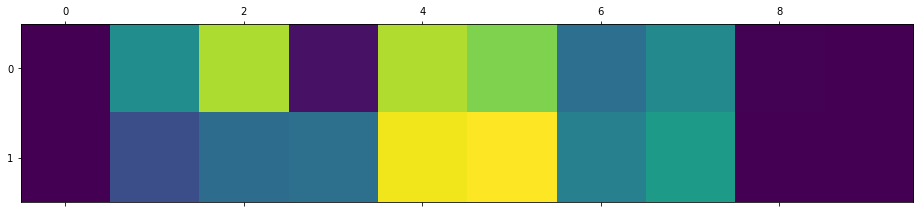

In [19]:
plt.matshow(data.sum().values.reshape(10,2).T)